In [1]:
import importlib.util, xarray as xr
print("netCDF4  : ", importlib.util.find_spec("netCDF4") is not None)
print("h5netcdf : ", importlib.util.find_spec("h5netcdf") is not None)
print("Back-ends:", xr.backends.list_engines())

netCDF4  :  True
h5netcdf :  True
Back-ends: {'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


In [2]:
ds = xr.open_dataset("NH3_Interpolated_IASI_AB_201901_202205_merged_satellite.nc")
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 41, lat: 104, lon: 97)
Coordinates:
  * lat      (lat) float64 832B 33.36 33.47 33.58 33.69 ... 44.28 44.39 44.5
  * lon      (lon) float64 776B -9.713 -9.574 -9.435 ... 3.348 3.487 3.626
  * time     (time) datetime64[ns] 328B 2019-01-31 2019-02-28 ... 2022-05-31
Data variables:
    NH3      (time, lat, lon) float64 3MB ...
Attributes:
    title:        Interpolated NH3 Grid Data (IASI)
    units:        molecules/cm² x E16
    description:  Monthly NH3 data interpolated to a regular 12km grid


✓ wrote fig_total/NH3_emission_total_2019-2022.png


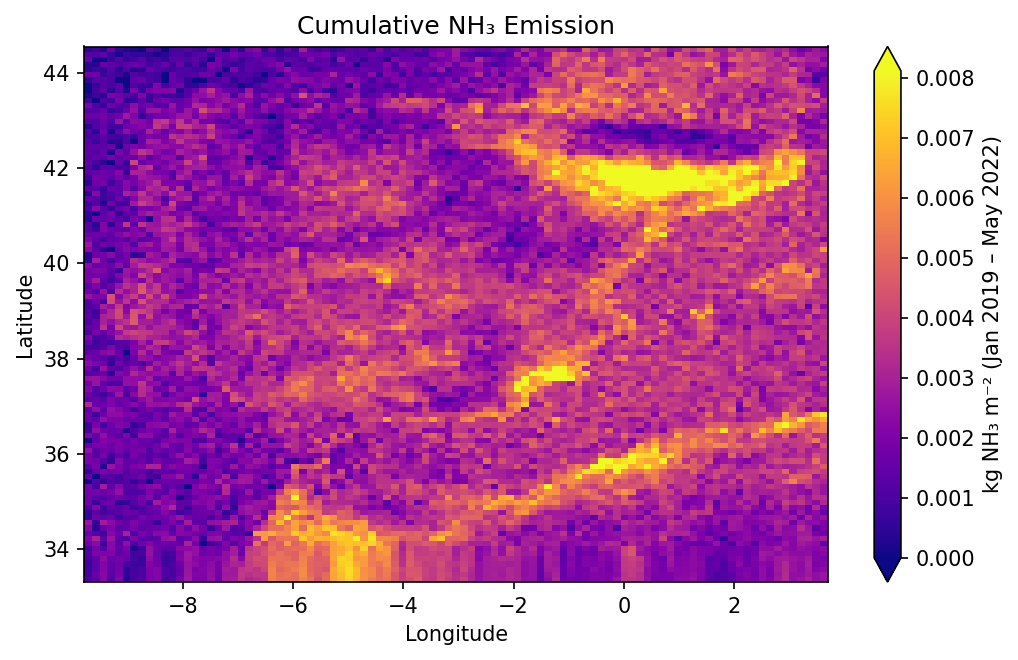

In [4]:
import xarray as xr, numpy as np, pathlib, matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1.  Load NH3 columns (molecules cm-2 x1e16) and convert to kg m-2
# -------------------------------------------------------------------
ds = xr.open_dataset("NH3_Interpolated_IASI_AB_201901_202205_merged_satellite.nc")

MW, AVO, CM2_M2 = 17.031, 6.02214076e23, 1e4        # g mol-1, mol-1, cm2→m2
mass = (ds.NH3 * 1e16 * CM2_M2 / AVO) * MW / 1000   # kg NH3 m-2

# -------------------------------------------------------------------
# 2.  Source flux with a 12 h lifetime
# -------------------------------------------------------------------
tau = 12 * 3600                                     # s
secs = ds.time.dt.days_in_month * 86_400            # seconds each month
emission_month = (mass / tau) * secs                # kg m-2 per month

# -------------------------------------------------------------------
# 3.  3.5-year total emission
# -------------------------------------------------------------------
emission_total = emission_month.sum(dim="time")     # kg m-2, Jan-2019→May-2022
emission_total.name = "NH3_emission_3.5yr"

# -------------------------------------------------------------------
# 4.  Quick map
# -------------------------------------------------------------------
vmax = np.nanpercentile(emission_total, 99)         # robust colour bar
fig, ax = plt.subplots(figsize=(7,4.5), dpi=150)
pcm = emission_total.plot(
        ax=ax, cmap="plasma", vmin=0, vmax=vmax,
        cbar_kwargs={"label": "kg NH₃ m⁻² (Jan 2019 – May 2022)"})
ax.set_title("Cumulative NH₃ Emission")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
path = pathlib.Path("fig_total"); path.mkdir(exist_ok=True)
plt.tight_layout(); fig.savefig(path/"NH3_emission_total_2019-2022.png")
print("✓ wrote fig_total/NH3_emission_total_2019-2022.png")